# Handwritten Digit Generator
In this notebook, we will build a ganerative adversarial network to generate handwritten digit. Thanks to Udacity providing study material!

## Brief Intro on GAN network
The idea behind GANs is that there are two networks - a generator G and a discriminator D - competing against each other. The generator create fake data to pass to the discriminator. The discriminator also have sees real data and judge whether input data is fake or real. The purpose of generator is to fool the discriminator, which means to create data that looks as close as possible to real data. The purpose of discriminator is to figure out which data is real and which is fake. At the end of training, generator is able to create data very close to real ones. 

The visualization is attached below:

![GAN_Diagram.png](https://c1.staticflickr.com/1/973/27850668338_4671349d77_b.jpg)

Now, let us build this GAN network!

In [1]:
# Firstly, import packages and data!
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model Inputs
After importing data, it is the time to create model inputs. For GAN network, we need two inputs, one for the discriminator - inputs_real and one for the generator - inputs_fake. In the model inputs function, we set appropriate sizes and placeholder for inputs.

In [2]:
def model_inputs(real_dim, fake_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_fake = tf.placeholder(tf.float32, (None, fake_dim), name='input_fake')
    return inputs_real, inputs_fake

## GAN structure
In this part, we start to build the network, looks like below
![GAN.png](https://c1.staticflickr.com/1/977/39912695390_934e054ff8_b.jpg)
In GAN network, we use Leaky ReLu for our hidden layer to prevent dying nodes.

In [33]:
# Create discriminator
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Add leaky relu as activation function\
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [34]:
# Create generator
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out
    

## Hyperparameters
After creating discriminator and generator, we set corresponding hyperparameters: 

In [35]:
input_size = 28 * 28
z_size = 100
# Size of hidden layers for generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# parameter for leaky ReLU
alpha = 0.01
# Smoothing
smooth = 0.1


## Construct network

In [36]:
tf.reset_default_graph()
# Create input placeholder
input_real, input_z = model_inputs(input_size, z_size)

# Build the model
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

# Two discriminators, one for real data, one for fake data
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)


## Discriminator and Generator Losses

In [38]:
d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                        labels=tf.ones_like(
                                                        d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                        labels=tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                   labels=tf.ones_like(d_logits_fake)))

## Optimizers

In [43]:
learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [53]:
batch_size = 100
epochs = 100
samples = []
losses = []

saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # reshape and rescale image to certain dim
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run Optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the each end of the epoch, get the losses and print out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print("Epoch {}/{}...".format(e + 1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}...".format(train_loss_g))
        
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                      generator(input_z, input_size, reuse=True),
                      feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')           

Epoch 1/100... Discriminator Loss: 0.3939... Generator Loss: 4.2752...
Epoch 2/100... Discriminator Loss: 0.3470... Generator Loss: 4.7495...
Epoch 3/100... Discriminator Loss: 0.4102... Generator Loss: 3.7426...
Epoch 4/100... Discriminator Loss: 0.4155... Generator Loss: 3.6919...
Epoch 5/100... Discriminator Loss: 0.5119... Generator Loss: 6.2799...
Epoch 6/100... Discriminator Loss: 0.6413... Generator Loss: 3.5367...
Epoch 7/100... Discriminator Loss: 0.7968... Generator Loss: 3.4813...
Epoch 8/100... Discriminator Loss: 0.6435... Generator Loss: 3.8280...
Epoch 9/100... Discriminator Loss: 0.9525... Generator Loss: 3.2470...
Epoch 10/100... Discriminator Loss: 0.9951... Generator Loss: 1.4906...
Epoch 11/100... Discriminator Loss: 0.8319... Generator Loss: 2.8208...
Epoch 12/100... Discriminator Loss: 0.9786... Generator Loss: 2.1802...
Epoch 13/100... Discriminator Loss: 0.8509... Generator Loss: 1.8822...
Epoch 14/100... Discriminator Loss: 1.2607... Generator Loss: 1.3219...
E

In [54]:
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples,f)

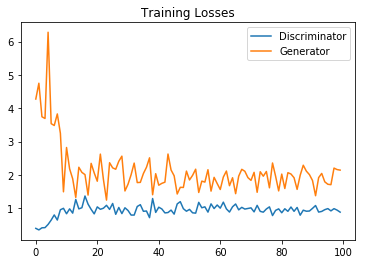

In [56]:
## View training loss
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
def view